In [14]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats as stats
from functools import partial
import multiprocessing
import seaborn as sns

In [15]:
# Script to merge MIMIC metadata with labels
MIMIC_CXR_PATH = '/srv/store/Data/MIMIC-CXR-JPG/'
# Set to '.jpg' if using MIMIC-CXR-JPG or '.dcm' if using MIMIC-CXR (DICOM)
FILE_PREFIX = '.jpg'

LABELS = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']

metadata = pd.read_csv(os.path.join(MIMIC_CXR_PATH, 'mimic-cxr-2.0.0-metadata.csv.gz'))
labels = pd.read_csv(os.path.join(MIMIC_CXR_PATH, 'mimic-cxr-2.0.0-chexpert.csv.gz'))
labels[LABELS] = labels[LABELS].fillna(0)
labels[LABELS] = labels[LABELS].replace(-1.0, 0.0)
labels['No Finding'] = (~labels[LABELS].astype(bool).any(axis=1)).astype(int)

metadata = metadata.merge(labels, on=['subject_id', 'study_id'])
metadata['path'] = 'files/p' + metadata['subject_id'].astype(str).str.slice(0,2) + '/p' + metadata['subject_id'].astype(str) + '/s' + metadata['study_id'].astype(str) + '/' + metadata['dicom_id'] + FILE_PREFIX

In [16]:
# Drop all other columns
metadata = metadata[['path', 'subject_id', 'No Finding']]

# Drop all patients inconsistently reported races
admission_df = pd.read_csv('admissions.csv.gz', compression='gzip')
admission_df = admission_df[['subject_id', 'race']]
admission_df = admission_df.rename(columns={"race": "Race"})
admission_df = admission_df.drop_duplicates()
admission_df = admission_df[~admission_df['subject_id'].duplicated(keep=False)]
metadata = metadata.merge(admission_df, on='subject_id').drop('subject_id', axis=1)

# Filter out NaN/other ethnicities
metadata = metadata[~metadata['Race'].isin(['OTHER', 'UNKNOWN', 'UNABLE TO OBTAIN', 'MULTIPLE RACE/ETHNICITY', 'PATIENT DECLINED TO ANSWER', 'AMERICAN INDIAN/ALASKA NATIVE', 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'])]
metadata = metadata[~metadata['Race'].isna()]
# Fix typo (columbian -> colombian)
metadata['Race'] = metadata['Race'].str.replace('COLUMBIAN', 'COLOMBIAN')
# Make scheme consistent
metadata['Race'] = metadata['Race'].replace('PORTUGUESE', 'WHITE - PORTUGUESE')
metadata['Race'] = metadata['Race'].replace('SOUTH AMERICAN', 'HISPANIC/LATINO - SOUTH AMERICAN')
metadata['Race'] = metadata['Race'].replace('HISPANIC OR LATINO', 'HISPANIC/LATINO')
metadata['Race'] = metadata['Race'].replace('ASIAN - ASIAN INDIAN', 'ASIAN - INDIAN')

# Convert to non-coarse race groups
metadata['Race Group'] = metadata['Race'].replace(' -.*', '', regex=True).replace('BLACK/.*', 'BLACK', regex=True)
# Remove non-coarse groups from prefix
metadata['Race'] = metadata['Race'].replace('BLACK/', '', regex=True).replace('WHITE - ', '', regex=True).replace('ASIAN - ', '', regex=True).replace('HISPANIC/LATINO - ', '', regex=True)
# Highlight coarse group with same name as non-coarse group
metadata['Race'] = metadata['Race'].replace('ASIAN', 'ASIAN*').replace('WHITE', 'WHITE*').replace('HISPANIC/LATINO', 'HISPANIC/LATINO*')

In [17]:
metadata['Race'].unique(), metadata['Race Group'].unique()

(array(['WHITE*', 'AFRICAN AMERICAN', 'RUSSIAN', 'PORTUGUESE',
        'CAPE VERDEAN', 'ASIAN*', 'CHINESE', 'GUATEMALAN', 'BRAZILIAN',
        'PUERTO RICAN', 'OTHER EUROPEAN', 'CARIBBEAN ISLAND',
        'EASTERN EUROPEAN', 'SOUTH EAST ASIAN', 'DOMINICAN',
        'HISPANIC/LATINO*', 'CUBAN', 'INDIAN', 'AFRICAN', 'COLOMBIAN',
        'CENTRAL AMERICAN', 'HONDURAN', 'SALVADORAN', 'KOREAN',
        'SOUTH AMERICAN', 'MEXICAN'], dtype=object),
 array(['WHITE', 'BLACK', 'ASIAN', 'HISPANIC/LATINO'], dtype=object))

In [18]:
def __bootstrapped_fpr(y_true, y_preds, n_models, idx):
  scores = []
  for i in range(n_models):
    tn, fp, _, _ = metrics.confusion_matrix(y_true[idx], y_preds[i][idx], labels=[0,1]).ravel()
    if tn + fp != 0:
      scores += [fp/(tn + fp)]
  if len(scores) != 0:
    return np.mean(scores)

def bootstrapped_fpr(y_true, y_preds, p=0.05, n_iterations=1000, seed=101, raw_scores=False):
  # Test set size
  n_samples = len(y_true)
  n_models = len(y_preds)
  idx = np.random.RandomState(seed).choice(np.arange(n_samples), (n_iterations, n_samples), replace=True)
  # Use multithreading to speed things up
  count = multiprocessing.cpu_count()
  with multiprocessing.Pool(processes=count) as pool:
    scores = np.array(pool.map(partial(__bootstrapped_fpr, y_true, y_preds, n_models), idx))
  scores = np.sort(scores[scores != None])
  if raw_scores:
    # For debugging
    return scores
  else:
    mean = np.nanmean(scores)
    ll, ul = np.nanquantile(scores, q=(0.025, 0.975))
    return mean, (ll, ul)

def bootstrapped_fpr_ttest(y_true1, y_preds1, y_true2, y_preds2, p=0.05, n_iterations=1000, seed=101, plot=False):
  # Bootstrap sample 1
  # Test set size
  n_samples = len(y_true1)
  n_models = len(y_preds1)
  idx = np.random.RandomState(seed).choice(np.arange(n_samples), (n_iterations, n_samples), replace=True)
  # Use multithreading to speed things up
  count = multiprocessing.cpu_count()
  with multiprocessing.Pool(processes=count) as pool:
    scores1 = np.array(pool.map(partial(__bootstrapped_fpr, y_true1, y_preds1, n_models), idx))
  # Bootstrap sample 2
  # Test set size
  n_samples = len(y_true2)
  n_models = len(y_preds2)
  idx = np.random.RandomState(seed).choice(np.arange(n_samples), (n_iterations, n_samples), replace=True)
  # Use multithreading to speed things up
  with multiprocessing.Pool(processes=count) as pool:
    scores2 = np.array(pool.map(partial(__bootstrapped_fpr, y_true2, y_preds2, n_models), idx))
  # FPR disparity
  diff = scores1 - scores2
  # One-sample two-sided t-test
  _, pval = stats.ttest_1samp(diff, 0, nan_policy='raise')
  return pval

In [19]:
# NOTE: Select model
# Train on MIMIC, test on MIMIC (N=25,888)
model = 'MIMIC'
# Train on CheXpert, test on MIMIC (N=270,136)
# model = 'CheXpert'

# Use correct seeds for model
if model == 'MIMIC':
  seeds = [24, 36, 70, 88, 100]
elif model == 'CheXpert':
  seeds = [3, 6, 14, 96, 99]

In [20]:
# Fetch ids for images in test set
test_imgs = pd.read_csv(f'{model}/True_{seeds[0]}.csv')['path'].values
# Filter test set from global metadata
df_test = metadata[metadata['path'].isin(test_imgs)]
# Merge preds from all 5 CXR models with test set metadata
for seed in seeds:
  df_pred = pd.read_csv(f'{model}/preds_{seed}.csv')[['path', 'prob_No Finding']]
  df_pred.columns = ['path', f'prob_No Finding_{seed}']
  df_test = df_test.merge(df_pred, on='path')
  
# Apply optimal F1 thresholding to proba
y_true = df_test['No Finding']
for seed in seeds:
  y_pred = df_test[f'prob_No Finding_{seed}']
  # Optimal F1 Thresholding
  precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_pred)
  f1_scores = 2*recall*precision/(recall + precision)
  opt_threshold = thresholds[np.argmax(f1_scores)]
  y_pred = (y_pred >= opt_threshold).astype(int)
  df_test[f'pred_No Finding_{seed}'] = y_pred
  
# Sanity check!
df_test.shape

(25888, 14)

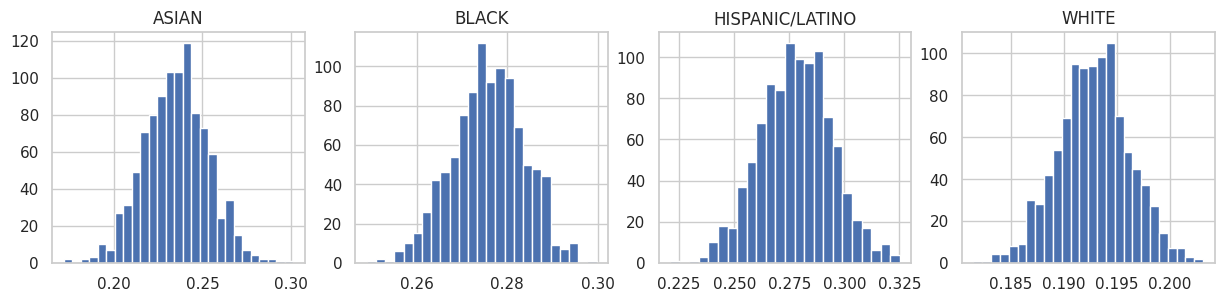

In [21]:
# Sanity check if the FPR scores after bootstrapping are normally distributed (to ensure robustness of t-test)
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for i, race_group in enumerate(np.sort(df_test['Race Group'].unique())):
  df_rg = df_test[df_test['Race Group'] == race_group]
  y_true = df_rg['No Finding'].values
  y_preds = []
  for seed in seeds:
    y_preds += [df_rg[f'pred_No Finding_{seed}'].values] 
  scores = bootstrapped_fpr(y_true, y_preds, n_iterations=1000, raw_scores=True)
  axes[i].hist(scores, bins='auto')
  axes[i].set_title(race_group)
plt.show()

In [22]:
# Bootstrap and return mean (95% CI) for all coarse and granular race groups
results = []
for race_group in np.sort(df_test['Race Group'].unique()):
  df_rg = df_test[df_test['Race Group'] == race_group]
  y_true = df_rg['No Finding'].values
  y_preds = []
  for seed in seeds:
    y_preds += [df_rg[f'pred_No Finding_{seed}'].values] 
  mean, (ll, ul) = bootstrapped_fpr(y_true, y_preds, n_iterations=1000)
  print(f'{race_group} - {np.around(mean*100, 2)} ({np.around(ll*100, 2)}, {np.around(ul*100, 2)})')
  results += [[race_group, '', mean, ll, ul]]
  
  for race in np.sort(df_rg['Race'].unique()):
    df_r = df_rg[df_rg['Race'] == race]
    y_true = df_r['No Finding'].values
    y_preds = []
    for seed in seeds:
      y_preds += [df_r[f'pred_No Finding_{seed}'].values] 
    mean, (ll, ul) = bootstrapped_fpr(y_true, y_preds, n_iterations=1000)
    print(f'{race_group} - {race} - {np.around(mean*100, 2)} ({np.around(ll*100, 2)}, {np.around(ul*100, 2)})')
    results += [[race_group, race, mean, ll, ul]]
results_df = pd.DataFrame(np.array(results), columns=['Race Group', 'Race', 'Mean_FPR', 'FPR_CILL', 'FPR_CIUL']).sort_values(['Race Group', 'Race'])
results_df[['Mean_FPR', 'FPR_CILL', 'FPR_CIUL']] = results_df[['Mean_FPR', 'FPR_CILL', 'FPR_CIUL']].astype(float)

ASIAN - 23.49 (20.04, 26.93)
ASIAN - ASIAN* - 19.52 (13.77, 25.68)
ASIAN - CHINESE - 25.02 (19.34, 30.51)
ASIAN - INDIAN - 36.22 (20.97, 51.34)
ASIAN - KOREAN - 40.39 (20.85, 61.26)
ASIAN - SOUTH EAST ASIAN - 16.52 (9.35, 24.29)
BLACK - 27.58 (26.04, 28.97)
BLACK - AFRICAN - 39.22 (26.66, 51.77)
BLACK - AFRICAN AMERICAN - 27.72 (26.14, 29.52)
BLACK - CAPE VERDEAN - 34.45 (27.57, 41.21)
BLACK - CARIBBEAN ISLAND - 15.64 (10.89, 20.59)
HISPANIC/LATINO - 27.81 (24.57, 31.05)
HISPANIC/LATINO - CENTRAL AMERICAN - 100.0 (100.0, 100.0)
HISPANIC/LATINO - COLOMBIAN - 89.76 (71.99, 100.0)
HISPANIC/LATINO - CUBAN - 31.15 (15.7, 48.0)
HISPANIC/LATINO - DOMINICAN - 18.45 (14.19, 22.55)
HISPANIC/LATINO - GUATEMALAN - 11.94 (3.85, 21.19)
HISPANIC/LATINO - HISPANIC/LATINO* - 52.47 (37.29, 67.65)
HISPANIC/LATINO - HONDURAN - 0.0 (0.0, 0.0)
HISPANIC/LATINO - MEXICAN - 26.25 (6.67, 45.56)
HISPANIC/LATINO - PUERTO RICAN - 34.89 (28.55, 41.38)
HISPANIC/LATINO - SALVADORAN - 39.13 (18.0, 61.25)
HISPANIC/LATI

/home/pkulkarni/miniconda3/envs/cxr_granular_bias/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pkulkarni/miniconda3/envs/cxr_granular_bias/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/pkulkarni/miniconda3/envs/cxr_granular_bias/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


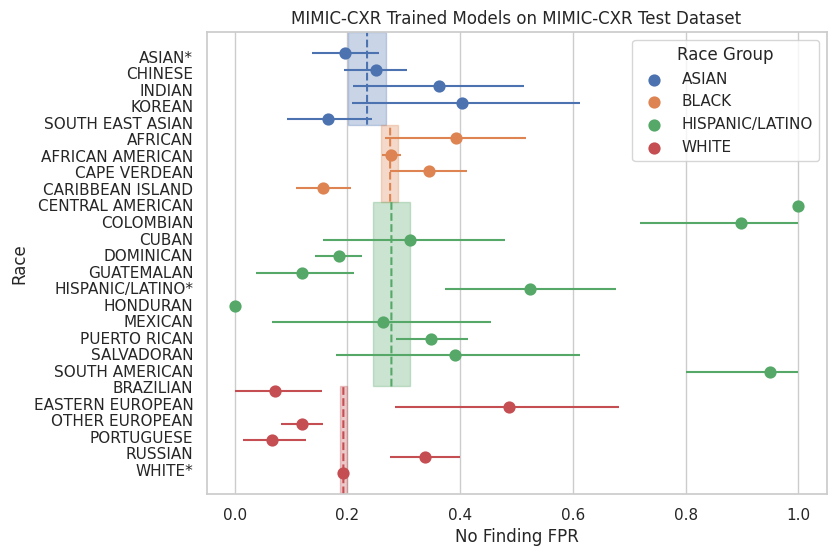

In [23]:
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))

race_normalized_counts = results_df['Race Group'].value_counts() / results_df['Race Group'].count()

# Non-coarse overall group metrics
race_groups = results_df['Race Group'].unique()
race_groups_df = results_df[results_df['Race'] == '']
for i, race_group in enumerate(race_groups):
  _, _, mean, ll, ul = race_groups_df[race_groups_df['Race Group'] == race_group].values.ravel()
  y_max = 1-sum([race_normalized_counts[race_groups[j]] for j in range(i)])
  y_min = y_max-race_normalized_counts[race_groups[i]]
  plt.axvspan(ll, ul, y_min, y_max, color = sns.color_palette(palette = None, n_colors = 4)[i], alpha=0.3)
  plt.axvline(x = mean, ymin = y_min, ymax = y_max, color = sns.color_palette(palette = None, n_colors = 4)[i], linestyle = 'dashed', snap=False)
  
race_df = results_df[results_df['Race'] != '']
ax = sns.pointplot(x='Mean_FPR', y='Race', hue='Race Group', data=race_df, dodge=0.4, join=False, hue_order=race_groups)

x_coords = []
y_coords = []
for point_pair in ax.collections:
  for x, y in point_pair.get_offsets():
    x_coords.append(x)
    y_coords.append(y)
        
indices = [x_coords.index(item) for item in x_coords if item >= 0]
x_coords = [x_coords[i] for i in indices]
y_coords = [y_coords[i] for i in indices]

fpr_mean = race_df['Mean_FPR'].values
fpr_ll = race_df['FPR_CILL'].values
fpr_ul = race_df['FPR_CIUL'].values

plt.errorbar(x=x_coords[0:5], y = y_coords[0:5], xerr=((fpr_mean[0:5] - fpr_ll[0:5]), (fpr_ul[0:5] - fpr_mean[0:5])), fmt='None', color= sns.color_palette(palette = None, n_colors = 4)[0], zorder = 4)
plt.errorbar(x=x_coords[5:9], y = y_coords[5:9], xerr=((fpr_mean[5:9] - fpr_ll[5:9]), (fpr_ul[5:9] - fpr_mean[5:9])), fmt='None', color= sns.color_palette(palette = None, n_colors = 4)[1], zorder = 4)
plt.errorbar(x=x_coords[9:20], y = y_coords[9:20], xerr=((fpr_mean[9:20] - fpr_ll[9:20]), (fpr_ul[9:20] - fpr_mean[9:20])), fmt='None', color= sns.color_palette(palette = None, n_colors = 4)[2], zorder = 4)
plt.errorbar(x=x_coords[20:26], y = y_coords[20:26], xerr=((fpr_mean[20:26] - fpr_ll[20:26]), (fpr_ul[20:26] - fpr_mean[20:26])), fmt='None', color= sns.color_palette(palette = None, n_colors = 4)[3], zorder = 4)

# Set plot title and labels
# NOTE: Uncomment below line to scale x-axis consistently for both models
# plt.xlim(-0.05, 1.05)
plt.xlabel('No Finding FPR')
plt.ylabel('Race')
if model == 'MIMIC':
  plt.title('MIMIC-CXR Trained Models on MIMIC-CXR Test Dataset')
  plt.savefig('fig_mimic_bootstrapped_fig.png', bbox_inches='tight', dpi=300)
elif model == 'CheXpert':
  plt.title('CheXpert Trained Models on Entire MIMIC-CXR Dataset')
  plt.savefig('fig_chexpert_bootstrapped_fig.png', bbox_inches='tight', dpi=300)
# Show the plot
plt.show()

In [26]:
# Pairs of granular race groups with lowest to highest FPR in each coarse group
if model == 'MIMIC':
  pairs = [
    ['SOUTH EAST ASIAN', 'KOREAN'],
    ['CARIBBEAN ISLAND', 'AFRICAN'],
    ['GUATEMALAN', 'COLOMBIAN'],
    ['PORTUGUESE', 'EASTERN EUROPEAN']
  ]
elif model == 'CheXpert':
  pairs = [
    ['KOREAN', 'INDIAN'],
    ['CAPE VERDEAN', 'AFRICAN'],
    ['CENTRAL AMERICAN', 'COLOMBIAN'],
    ['WHITE*', 'PORTUGUESE']
  ]
for race_x, race_y in pairs:
  # Sample 1
  df_x = df_test[df_test['Race'] == race_x]
  y_true1 = df_x['No Finding'].values
  y_preds1 = []
  for seed in seeds:
    y_preds1 += [df_x[f'pred_No Finding_{seed}'].values]
  # Sample 2
  df_y = df_test[df_test['Race'] == race_y]
  y_true2 = df_y['No Finding'].values
  y_preds2 = []
  for seed in seeds:
    y_preds2 += [df_y[f'pred_No Finding_{seed}'].values]
  # FPR disparity t-test
  pval = bootstrapped_fpr_ttest(y_true1, y_preds1, y_true2, y_preds2)
  print(f'{race_x} - {race_y} - p-value: {pval}')

SOUTH EAST ASIAN - KOREAN - p-value: 0.0
CARIBBEAN ISLAND - AFRICAN - p-value: 0.0
GUATEMALAN - COLOMBIAN - p-value: 0.0
PORTUGUESE - EASTERN EUROPEAN - p-value: 0.0


In [27]:
from itertools import permutations
pairs = list(permutations(df_test['Race Group'].unique(), 2))
for race_x, race_y in pairs:
  # Sample 1
  df_x = df_test[df_test['Race Group'] == race_x]
  y_true1 = df_x['No Finding'].values
  y_preds1 = []
  for seed in seeds:
    y_preds1 += [df_x[f'pred_No Finding_{seed}'].values]
  # Sample 2
  df_y = df_test[df_test['Race Group'] == race_y]
  y_true2 = df_y['No Finding'].values
  y_preds2 = []
  for seed in seeds:
    y_preds2 += [df_y[f'pred_No Finding_{seed}'].values]
  # FPR t-test
  pval = bootstrapped_fpr_ttest(y_true1, y_preds1, y_true2, y_preds2,n_iterations=1000)
  print(f'{race_x} - {race_y} - p-value: {pval}')

WHITE - BLACK - p-value: 0.0
WHITE - ASIAN - p-value: 0.0
WHITE - HISPANIC/LATINO - p-value: 0.0
BLACK - WHITE - p-value: 0.0
BLACK - ASIAN - p-value: 0.0
BLACK - HISPANIC/LATINO - p-value: 6.668677636181361e-05
ASIAN - WHITE - p-value: 0.0
ASIAN - BLACK - p-value: 0.0
ASIAN - HISPANIC/LATINO - p-value: 1.378606e-317
HISPANIC/LATINO - WHITE - p-value: 0.0
HISPANIC/LATINO - BLACK - p-value: 6.668677636181361e-05
HISPANIC/LATINO - ASIAN - p-value: 1.378606e-317
